# Guia de Entrenamiento Simple
Esta guia contiene un modelo algo simple, se muestran las funcioens principales
- Existe ademas una versión alternativa a `model.fit` que funciona más manual y no presenta el memory leak de la original
- Se muestra como funciona la carga de datos y de sub modelos pre adaptados para escalar correctamente los datos o parametrizarlos


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import grav_lens.preprocess as gp
from grav_lens.utils.statistics import get_stats
from grav_lens.preprocess.filtering import process_batch_filters


from grav_lens import get_datasets
max_files = 2000
batch_size = 64
home_data = os.path.join("..","data")

train_dataset, val_dataset, test_dataset = get_datasets(
    data_index=1,
    max_files=max_files,
    home=home_data,
    batch_size=batch_size,
    val_split=0.2,
    test_split=0.1,
)

for X_batch, y_batch in train_dataset.take(1):
    print(X_batch.shape)
    print(y_batch.shape)



Using data folder: ..\data\1
(64, 128, 128, 3)
(64, 128, 128, 1)


### Sobre el funcionamiento del preprocesamiento

Escalamiento
- Los datos se escalan previamente mediante un modelo MinMaxScaler pre entrenado con los 70000 datos de training, por lo que se requiere de hacer transformaciones inversas a la hora de publicar los resultados

Procesamiento parametrico
- Primero se separan usando Fourier en frecuencias altas y bajas, con apriximadamente un corte del 5%
- Se utilizan modelos PCA para convertir coeficientes de las imagenes de baja frecuencia en coeficientes, osea que son descritos por una superposición de ondas.
    Los datos de baja frecuencia demsotrarón tener una varianza más facil de capturar con suma de modos
- Se utiliza un GMM (Modelo de Mix de Gaussianas) para los datos de alta frecuencia, representando peaks más concentrados y detallados
    Los datos de alta frecuencia son muy distintos para cada modelo

In [2]:
from grav_lens.models.load_models import load_minmaxscaler, load_ipca_low
# Cargar el MinMaxScaler
minmaxscaler = load_minmaxscaler()
print(minmaxscaler)
# Cargar el modelo IPCA low
ipca_low = load_ipca_low()
print(ipca_low)



IncrementalPCA(batch_size=64, n_components=64)


## Mini tutorial de las funciones más usadas
Algunas funciones de utilidad
- gp.apply_threshold
- gp.gmm_batch_vectors

In [3]:
# se puede separar por encima o abjao de un punto de corte
batch_positive, batch_negative =   gp.apply_threshold(y_batch, *get_stats(y_batch))

In [4]:
# separa en baja y alta frecuencia 5.2 s por batch
low_batch, high_batch = process_batch_filters(y_batch)

- Los componentes de baja frecuencia son bien aproximados por componentes principales
- Los componentes de alta frecuencia son bien aproximados por peaks gaussianos

In [5]:
gp.gmm_batch_vectors?

Signature:
gp.gmm_batch_vectors(
    batch,
    n_gaussians_positive=30,
    n_gaussians_negative=10,
    threshold=2,
    n_points=500,
    scale=0.5,
    density_threshold=0.05,
    density_scaling=True,
    pos_reg_covar=1e-06,
    pos_tol=0.001,
    neg_reg_covar=1e-06,
    neg_tol=0.001,
)
Docstring:
Aplica modelos de mezclas gaussianas (GMM) a un batch de imágenes escaladas, generando vectores de medias, desviaciones estándar y pesos.
Luego, reescala las gaussianas para que correspondan a la resolución original y las ordena por la magnitud de sus pesos.


Esta función primero reduce la resolución de las imágenes de entrada, aplica un modelo GMM para extraer las componentes gaussianas
positivas y negativas, y finalmente reescala las gaussianas a la resolución original. Se usa para aproximar las distribuciones
de alta y baja frecuencia en las imágenes.

Parámetros:
    batch (numpy.ndarray):  Batch de imágenes a procesar con shape (batch_size, altura, anchura, 1).
    n_gaussians_p

In [6]:
# 15 s por batch
# (batch, 40, 5) 
# 40 es el total de gaussianas
# 5 el vector correspondiente a cada gaussiana
gaussians = gp.gmm_batch_vectors(high_batch)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 30 and the array at index 1 has size 10

# El proceso completo
De manera que tenemos las dos formas principales de datos
- gaussians (batch, 40, 5), con 40 el total de gaussianas, 5 el largo del vector de info: 
    meanx, meany, stdx, stdy, coef
- principal_components (batch, 64), con 64 coeficientes que representan cuanto hay de cada componente


In [38]:
N_GAUSS = 40

In [39]:
def preprocess_ybatch(y_batch, corte=2):
    low_batch, high_batch = process_batch_filters(y_batch)

    # se agregaron tecnicas de regularización
    gaussians = gp.gmm_batch_vectors(high_batch, n_gaussians_positive=N_GAUSS, n_gaussians_negative=0, 
                                    threshold=corte, n_points=750, scale=0.75, density_threshold=0.01)

    low_freq_stack = np.vstack([img.reshape(-1, 128*128) for img in low_batch]) #stack para el pca
    principal_components = ipca_low.transform(low_freq_stack)
    return [principal_components, gaussians]

In [40]:
for X_batch, y_batch in train_dataset.take(1):
    y_batch = minmaxscaler.transform(y_batch) # [0, 1] #escalar los datos

    print(X_batch.shape)
    print(y_batch.shape)
    
    y_process = preprocess_ybatch(y_batch, corte=2)


(64, 128, 128, 3)
(64, 128, 128, 1)


# Creacion del Modelo
Es necesario que se pueda construir parametricamente, con distintas combinaciones
- considerar data agumentation con informacion fisica

In [41]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Función para construir el modelo CNN con dos ramas
def create_cnn_model(input_shape=(128, 128, 3), n_gaussians=N_GAUSS):
    """
    Crea un modelo CNN con dos ramas para predecir coeficientes de baja y alta frecuencia.

    Parámetros:
    -----------
    input_shape: tuple, opcional (default=(128, 128, 3))
        La forma de entrada de las imágenes.
    
    n_gaussians: int, opcional (default=40)
        Número de gaussianas en la predicción de alta frecuencia.

    Returns:
    --------
    model: tf.keras.Model
        Modelo de red neuronal con dos ramas: una para predecir coeficientes PCA de baja frecuencia
        y otra para predecir los parámetros de gaussianas de alta frecuencia.
    """
    
    # Definimos la entrada de la red
    input_img = layers.Input(shape=input_shape)

    # Primera capa CNN compartida con BatchNormalization y ReLU
    x = layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal')(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # División en dos ramas

    # Rama de baja frecuencia (lowfreq) - predicción de PCA
    low_freq = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    low_freq = layers.BatchNormalization()(low_freq)
    low_freq = layers.ReLU()(low_freq)
    low_freq = layers.MaxPooling2D(pool_size=(2, 2))(low_freq)
    low_freq = layers.Flatten()(low_freq)
    low_freq = layers.Dense(128, kernel_initializer='he_normal')(low_freq)
    low_freq = layers.BatchNormalization()(low_freq)
    low_freq = layers.LeakyReLU(negative_slope=0.2)(low_freq)
    # Usar 'linear' para que el output pueda ser cualquier valor
    low_freq_output = layers.Dense(64, activation='linear', name='lowfreq_output')(low_freq)

    # Rama de alta frecuencia (highfreq) - predicción de gaussianas
    high_freq = layers.Conv2D(64, (5, 5), padding='same', kernel_initializer='he_normal')(x)  # Diferente kernel size
    high_freq = layers.BatchNormalization()(high_freq)
    high_freq = layers.LeakyReLU(negative_slope=0.2)(high_freq)
    high_freq = layers.MaxPooling2D(pool_size=(2, 2))(high_freq)
    high_freq = layers.Flatten()(high_freq)
    high_freq = layers.Dense(128, kernel_initializer='he_normal')(high_freq)
    high_freq = layers.BatchNormalization()(high_freq)
    high_freq = layers.LeakyReLU(negative_slope=0.2)(high_freq)
    high_freq_output = layers.Dense(n_gaussians * 5, activation='linear', name='highfreq_output')(high_freq)  # 40 gaussianas * 5 parámetros
    high_freq_output = layers.Reshape((n_gaussians, 5))(high_freq_output)  # Reshape para que coincida con la salida gaussiana

    # Escalar los valores de salida de high_freq_output
    mean_x_y = layers.Activation('softplus', name='mean_x_y')(high_freq_output[..., :2])
    std_x_y = layers.Activation('softplus', name='std_x_y')(high_freq_output[..., 2:4])
    weights = layers.LeakyReLU(negative_slope=0.5, name='scaled_weights')(high_freq_output[..., 4])

    # Concatenar las salidas escaladas
    high_freq_output_scaled = layers.Concatenate(axis=-1)([mean_x_y, std_x_y, weights[..., tf.newaxis]])

    # Definir el modelo final con las dos ramas de salida
    model = models.Model(inputs=input_img, outputs=[low_freq_output, high_freq_output_scaled])

    return model

# Ejemplo de uso del modelo
cnn_model = create_cnn_model()
cnn_model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 128, 128,  │        896 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 64, 64,    │          0 │ conv2d_15[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 64, 64,    │     51,264 │ max_pooling2d_15… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 32, 32,    │          0 │ conv2d_17[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_11          │ (None, 65536)     │          0 │ max_pooling2d_17… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 256)       │ 16,777,472 │ flatten_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ highfreq_output     │ (None, 200)       │     51,400 │ dense_11[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_15… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 40, 5)     │          0 │ highfreq_output[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 32, 32,    │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_14         │ (None, 40)        │          0 │ reshape_5[0][0]   │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 65536)     │          0 │ max_pooling2d_16… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_12         │ (None, 40, 2)     │          0 │ reshape_5[0][0]   │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_13         │ (None, 40, 2)     │          0 │ reshape_5[0][0]   │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 40)        │          0 │ get_item_14[0][0] │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │  8,388,736 │ flatten_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 40, 2)     │          0 │ get_item_12[0][0

 Total params: 25,296,520 (96.50 MB)

 Trainable params: 25,296,520 (96.50 MB)

 Non-trainable params: 0 (0.00 B)

### Training

In [42]:
import tensorflow as tf
import numpy as np
import time

# callbacks
def prepare_callbacks(callbacks, model):
    if callbacks:
        for callback in callbacks:
            callback.set_model(model)
            callback.on_train_begin()
    return callbacks

def run_callbacks_on_epoch_end(callbacks, epoch, logs):
    if callbacks:
        for callback in callbacks:
            callback.on_epoch_end(epoch, logs=logs)

def run_callbacks_on_train_end(callbacks):
    if callbacks:
        for callback in callbacks:
            callback.on_train_end()


class TimeStopping(tf.keras.callbacks.Callback):
    def __init__(self, max_seconds=None):
        super(TimeStopping, self).__init__()
        self.max_seconds = max_seconds
        self.start_time = None

    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        elapsed_time = time.time() - self.start_time
        if elapsed_time > self.max_seconds:
            print(f'\nDetenido después de {elapsed_time:.2f} segundos.')
            self.model.stop_training = True

# --- optmizador

# Función para inicializar el optimizador con un scheduler
def get_optimizer_with_scheduler(optimizer_name='adam', initial_lr=0.001, scheduler=None, momentum=0.0, nesterov=False):
    """
    Inicializa el optimizador con un scheduler opcional.

    Parámetros:
        optimizer_name (str): Nombre del optimizador a utilizar ('adam' o 'sgd').
        initial_lr (float): Learning rate inicial.
        scheduler (tf.keras.optimizers.schedules, opcional): Scheduler para ajustar el learning rate durante el entrenamiento.
        momentum (float, opcional): Momento para el optimizador SGD (por defecto 0.0).
        nesterov (bool, opcional): Si usar Nesterov momentum para SGD (por defecto False).

    Retorna:
        tf.keras.optimizers.Optimizer: Optimizador inicializado.
    """
    # Si se proporciona un scheduler, usarlo como learning rate
    lr = scheduler if scheduler else initial_lr

    if optimizer_name.lower() == 'adam':
        return tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer_name.lower() == 'sgd':
        return tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum, nesterov=nesterov)
    else:
        raise ValueError("Optimizer not recognized. Please use 'adam' or 'sgd'.")

# -------
# Definir un scheduler personalizado (opcional)
def cosine_scheduler(epoch, lr):
    max_epochs = 30
    return lr * (tf.math.cos(epoch * np.pi / max_epochs) + 1) / 2

# Función para calcular la pérdida y las métricas (solo MSE en este caso)
def calculate_losses(y_true, y_pred, mse_fn):
    mse_loss = mse_fn(y_true, y_pred)
    return mse_loss

# Función para ejecutar el entrenamiento de una época
def train_epoch(model, train_dataset, optimizer, mse_fn, print_steps):
    train_mse_metric = tf.keras.metrics.Mean(name='train_mse')
    
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        # Preprocesar y_batch
        principal_components, gaussians = preprocess_ybatch(y_batch_train)
        
        with tf.GradientTape() as tape:
            # El modelo debe devolver las dos ramas: lowfreq y highfreq
            lowfreq_pred, highfreq_pred = model(x_batch_train, training=True)
            
            # Calcular pérdidas separadas para ambas ramas
            mse_loss_low = mse_fn(principal_components, lowfreq_pred)
            mse_loss_high = mse_fn(gaussians, highfreq_pred)
            
            # Sumar las pérdidas
            total_loss = mse_loss_low + mse_loss_high

        # Aplicar gradientes
        grads = tape.gradient(total_loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Actualizar la métrica MSE
        train_mse_metric(total_loss)

        # Mostrar progreso
        if step % print_steps == 0:
            print(f'Step {step}: Total MSE = {train_mse_metric.result().numpy()}, LowFreq MSE = {mse_loss_low.numpy()}, HighFreq MSE = {mse_loss_high.numpy()}')

    return train_mse_metric.result().numpy()

# Función para ejecutar la validación
def validate_epoch(model, val_dataset, mse_fn):
    val_mse_metric = tf.keras.metrics.Mean(name='val_mse')

    for val_x, val_y in val_dataset:
        # Preprocesar y_batch
        principal_components, gaussians = preprocess_ybatch(val_y)
        
        # El modelo debe devolver las dos ramas: lowfreq y highfreq
        lowfreq_pred, highfreq_pred = model(val_x, training=False)
        
        # Calcular pérdidas separadas para ambas ramas
        mse_loss_low = mse_fn(principal_components, lowfreq_pred)
        mse_loss_high = mse_fn(gaussians, highfreq_pred)
        
        # Sumar las pérdidas
        total_loss = mse_loss_low + mse_loss_high

        # Actualizar la métrica MSE
        val_mse_metric(total_loss)

    return val_mse_metric.result().numpy()


# Función para reiniciar métricas
def reset_metrics(metric):
    metric.reset_state()

# Función principal para entrenar el modelo
def train_model(epochs, model, train_dataset, val_dataset, optimizer, mse_fn, print_steps, callbacks=None):
    # Inicializar las métricas
    train_mse_metric = tf.keras.metrics.Mean(name='train_mse')
    val_mse_metric = tf.keras.metrics.Mean(name='val_mse')
    history = {'loss': [], 'val_loss': []}

    # Preparar callbacks
    callbacks = prepare_callbacks(callbacks, model)

    # Iterar sobre las épocas
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        # Entrenar una época
        train_loss = train_epoch(model, train_dataset, optimizer, mse_fn, print_steps)
        history['loss'].append(train_loss)

        # Validación
        val_loss = validate_epoch(model, val_dataset, mse_fn)
        history['val_loss'].append(val_loss)

        # Ejecutar callbacks al final de la época
        logs = {'loss': train_loss, 'val_loss': val_loss}
        run_callbacks_on_epoch_end(callbacks, epoch, logs)

        # Resetear métricas
        reset_metrics(train_mse_metric)
        reset_metrics(val_mse_metric)

    # Ejecutar callbacks al final del entrenamiento
    run_callbacks_on_train_end(callbacks)

    return history


In [43]:
# Early stopping callback basado en val_mse
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    mode="min",
    patience=5,  # Número de épocas sin mejora antes de detener
    restore_best_weights=True  # Restaurar los mejores pesos
)


scheduler = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=5000,  # Número de pasos antes de llegar a lr mínimo
    alpha=1e-6  # Valor final del learning rate (porcentaje del learning rate inicial)
)

callbacks = [
    early_stopping
]

In [44]:
# Definir el optimizador
# se puede usar 'adam'
optimizer = get_optimizer_with_scheduler('sgd', 1e-3, scheduler)

# Definir la función de pérdida MSE
mse_fn = tf.keras.losses.MeanSquaredError()

# Entrenar el modelo
history = train_model(
    epochs=10,                        # Número de épocas de entrenamiento
    model=cnn_model,                  # Modelo CNN que has definido con dos ramas
    train_dataset=train_dataset,      # Dataset de entrenamiento preprocesado
    val_dataset=val_dataset,          # Dataset de validación preprocesado
    optimizer=optimizer,              # Optimizador con el scheduler
    mse_fn=mse_fn,                    # Función de pérdida (MSE)
    print_steps=15,                   # Mostrar progreso cada 10 steps
    callbacks=callbacks               # Callbacks, incluyendo EarlyStopping y TimeStopping
)


Epoch 1/10
Step 0: Total MSE = 586.1554565429688, LowFreq MSE = 2.7954397201538086, HighFreq MSE = 583.3600463867188
Step 10: Total MSE = 682.111083984375, LowFreq MSE = 1.7921264171600342, HighFreq MSE = 584.7510986328125
Step 20: Total MSE = 640.4593505859375, LowFreq MSE = 1.9954924583435059, HighFreq MSE = 591.0040893554688


c:\Users\fbien.DESKTOP-6FMEAR7\Desktop\grav_lensing\venv\lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_mse` which is not available. Available metrics are: loss,val_loss
  current = self.get_monitor_value(logs)


Epoch 2/10
Step 0: Total MSE = 584.5979614257812, LowFreq MSE = 1.753835916519165, HighFreq MSE = 582.8441162109375
Step 10: Total MSE = 594.275634765625, LowFreq MSE = 1.3695785999298096, HighFreq MSE = 586.85205078125
Step 20: Total MSE = 591.0469970703125, LowFreq MSE = 1.0916810035705566, HighFreq MSE = 601.776123046875


c:\Users\fbien.DESKTOP-6FMEAR7\Desktop\grav_lensing\venv\lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_mse` which is not available. Available metrics are: loss,val_loss
  current = self.get_monitor_value(logs)


Epoch 3/10
Step 0: Total MSE = 580.3248291015625, LowFreq MSE = 1.137700080871582, HighFreq MSE = 579.1871337890625
Step 10: Total MSE = 591.2408447265625, LowFreq MSE = 1.0041213035583496, HighFreq MSE = 588.1461791992188
Step 20: Total MSE = 591.38232421875, LowFreq MSE = 0.9991715550422668, HighFreq MSE = 587.5648193359375


c:\Users\fbien.DESKTOP-6FMEAR7\Desktop\grav_lensing\venv\lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_mse` which is not available. Available metrics are: loss,val_loss
  current = self.get_monitor_value(logs)


Epoch 4/10
Step 0: Total MSE = 597.9038696289062, LowFreq MSE = 0.9951595067977905, HighFreq MSE = 596.90869140625
Step 10: Total MSE = 591.2620239257812, LowFreq MSE = 0.9983857870101929, HighFreq MSE = 578.828125
Step 20: Total MSE = 591.272216796875, LowFreq MSE = 0.9750508069992065, HighFreq MSE = 596.8457641601562


c:\Users\fbien.DESKTOP-6FMEAR7\Desktop\grav_lensing\venv\lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_mse` which is not available. Available metrics are: loss,val_loss
  current = self.get_monitor_value(logs)


Epoch 5/10
Step 0: Total MSE = 593.7852783203125, LowFreq MSE = 1.0460152626037598, HighFreq MSE = 592.7392578125
Step 10: Total MSE = 590.2268676757812, LowFreq MSE = 0.9986672401428223, HighFreq MSE = 584.1246948242188
Step 20: Total MSE = 589.9467163085938, LowFreq MSE = 0.9716173410415649, HighFreq MSE = 590.0020141601562


c:\Users\fbien.DESKTOP-6FMEAR7\Desktop\grav_lensing\venv\lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_mse` which is not available. Available metrics are: loss,val_loss
  current = self.get_monitor_value(logs)


Epoch 6/10
Step 0: Total MSE = 588.9735107421875, LowFreq MSE = 0.9790790677070618, HighFreq MSE = 587.9944458007812
Step 10: Total MSE = 590.590087890625, LowFreq MSE = 0.9189026355743408, HighFreq MSE = 599.1881103515625
Step 20: Total MSE = 590.6380004882812, LowFreq MSE = 0.9799472689628601, HighFreq MSE = 588.02587890625


c:\Users\fbien.DESKTOP-6FMEAR7\Desktop\grav_lensing\venv\lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_mse` which is not available. Available metrics are: loss,val_loss
  current = self.get_monitor_value(logs)


Epoch 7/10
Step 0: Total MSE = 589.5186157226562, LowFreq MSE = 0.9443041682243347, HighFreq MSE = 588.5743408203125
Step 10: Total MSE = 588.4314575195312, LowFreq MSE = 1.0715153217315674, HighFreq MSE = 584.1663818359375
Step 20: Total MSE = 590.129150390625, LowFreq MSE = 0.969304084777832, HighFreq MSE = 601.5132446289062


c:\Users\fbien.DESKTOP-6FMEAR7\Desktop\grav_lensing\venv\lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_mse` which is not available. Available metrics are: loss,val_loss
  current = self.get_monitor_value(logs)



Detenido después de 3807.66 segundos.
Epoch 8/10
Step 0: Total MSE = 590.3604125976562, LowFreq MSE = 0.9767085313796997, HighFreq MSE = 589.3837280273438
Step 10: Total MSE = 591.7501831054688, LowFreq MSE = 0.9735373258590698, HighFreq MSE = 586.5501708984375
Step 20: Total MSE = 590.5171508789062, LowFreq MSE = 0.9562236070632935, HighFreq MSE = 582.0776977539062


c:\Users\fbien.DESKTOP-6FMEAR7\Desktop\grav_lensing\venv\lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_mse` which is not available. Available metrics are: loss,val_loss
  current = self.get_monitor_value(logs)



Detenido después de 4352.67 segundos.
Epoch 9/10
Step 0: Total MSE = 593.108642578125, LowFreq MSE = 0.9432752132415771, HighFreq MSE = 592.1653442382812
Step 10: Total MSE = 589.6262817382812, LowFreq MSE = 1.0061191320419312, HighFreq MSE = 581.5405883789062
Step 20: Total MSE = 590.4526977539062, LowFreq MSE = 0.9776872992515564, HighFreq MSE = 591.58984375


c:\Users\fbien.DESKTOP-6FMEAR7\Desktop\grav_lensing\venv\lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_mse` which is not available. Available metrics are: loss,val_loss
  current = self.get_monitor_value(logs)



Detenido después de 4889.67 segundos.
Epoch 10/10
Step 0: Total MSE = 591.4839477539062, LowFreq MSE = 0.9550332427024841, HighFreq MSE = 590.5289306640625
Step 10: Total MSE = 591.1578369140625, LowFreq MSE = 1.0064688920974731, HighFreq MSE = 587.4169921875
Step 20: Total MSE = 591.1536254882812, LowFreq MSE = 1.014370083808899, HighFreq MSE = 580.3955688476562

Detenido después de 5431.73 segundos.


c:\Users\fbien.DESKTOP-6FMEAR7\Desktop\grav_lensing\venv\lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_mse` which is not available. Available metrics are: loss,val_loss
  current = self.get_monitor_value(logs)


In [ ]:
cnn_model.save('model_0925.keras')

## Reconstruccion
Actualmente las funciones de reconstrucción se encuentran implementadas dentro de la libreria y es posible verlas mediante la documentación
- `reconstruct_image_from_gmm` se encarga de tomar los vectores de las `N_GAUSS` gaussianas
- `reconstruct_batch_images` toma todo el batch de vectores y reconstruye el batch de imagenes
    utilizando e implementando `reconstruct_lowfreq_from_pca` y `reconstruct_highfreq_from_gmm`

In [53]:
from grav_lens.preprocess.gmm import reconstruct_batch_images, reconstruct_image_from_gmm, reconstruct_lowfreq_from_pca, reconstruct_highfreq_from_gmm


### reconstruccion perfecta

In [54]:
for X_batch, y_batch in train_dataset.take(1):
    y_batch = minmaxscaler.transform(y_batch) # [0, 1] #escalar los datos

    print(X_batch.shape)
    print(y_batch.shape)
    
    low_batch, high_batch = process_batch_filters(y_batch)


(64, 128, 128, 3)
(64, 128, 128, 1)


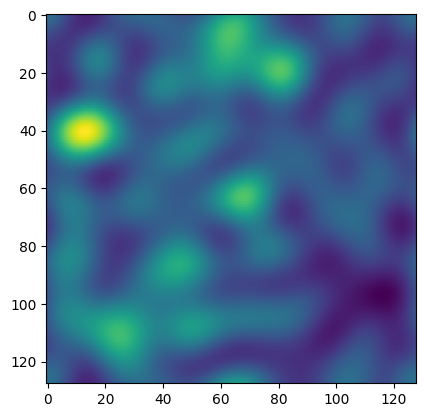

In [55]:
plt.imshow(low_batch[0,:,:,0])

### reconstruccion del modelo

In [58]:
for X_batch, y_batch in train_dataset.take(1):
    batch_size = X_batch.shape[0]
    predictions = cnn_model.predict(X_batch)
    reconstructed_images = reconstruct_batch_images(*predictions, batch_size)

    truth = preprocess_ybatch(y_batch)
    truth_reconstructed_images = reconstruct_batch_images(*truth, batch_size)

In [ ]:
import grav_lens.preprocess as gp

idx = 0
original = truth_reconstructed_images[idx,:,:,0]
reconstructed = reconstructed_images[idx,:,:,0]
gp.plot_comparison(original, reconstructed)